In [2]:
# Import Necessary Libraries
import numpy as np
import scipy.io

import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable


from sklearn.decomposition import PCA
import scipy.stats as stats
from scipy.spatial import distance as Distance

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

%matplotlib inline

In [3]:
######## Get list of files (.mat) we want to work with ########
filedir = '../condensed_data/blocks/'
sessions = os.listdir(filedir)
sessions = sessions[2:]

session_pval_dict = {}
# loop through each session
sessiondir = filedir + sessions[0]  
# get all blocks for this session
blocks = os.listdir(sessiondir)
block = blocks[0]
block_dir = sessiondir + '/' + block

# in each block, get list of word pairs from first and second block
wordpairs = os.listdir(block_dir)
channels = os.listdir(block_dir+'/'+wordpairs[0])

chan_order = []
for jdx, chan in sorted(enumerate(channels)):
    chan_order.append(chan)
# print chan_order
chan_order = np.array(chan_order)
print len(chan_order)

def binarize_pval_mat(pval_mat):
    pval_mat[pval_mat > 0.05] = 0.5
    pval_mat[pval_mat <= 0.05] = 1
    pval_mat[pval_mat == 0.5] = 0
    return pval_mat

96


In [4]:
data = np.load('../notebooks/high_freq_channel_analysis.npy').item()
print "looking at high frequencies"
print data.keys()

high_session_chans = {}
for session in data.keys():
    high_session_chans[session] = []
    session_pval_same_mat = data[session]['same']
    session_pval_diff_mat = data[session]['diff']
    session_pval_reverse_mat = data[session]['reverse']
    
    print "\nOn session: ", session
    ## DIFFERENT
    buff = binarize_pval_mat(session_pval_diff_mat)
    hist = np.sum(buff, axis=0)
    indices = hist>=3
    print "# channels with more then 3 significant blocks: ", len(chan_order[indices])
    high_session_chans[session].append(chan_order[indices])
    
    ## REVERSE
    buff = binarize_pval_mat(session_pval_reverse_mat)
    hist = np.sum(buff, axis=0)
    indices = hist>=3
    print "# channels with more then 3 significant blocks: ", len(chan_order[indices])
    
    ## Same word pairs
    buff = binarize_pval_mat(session_pval_same_mat)
    hist = np.sum(buff, axis=0)
    indices = hist>=3
    print "# channels with more then 3 significant blocks: ", len(chan_order[indices])

looking at high frequencies
['session_1', 'session_2']

On session:  session_1
# channels with more then 3 significant blocks:  11
# channels with more then 3 significant blocks:  3
# channels with more then 3 significant blocks:  0

On session:  session_2
# channels with more then 3 significant blocks:  7
# channels with more then 3 significant blocks:  0
# channels with more then 3 significant blocks:  0


In [5]:
print "high: ",high_session_chans

high:  {'session_1': [array(['35_TT3-global_groupSessionBlockData.mat',
       '39_OF1-global_groupSessionBlockData.mat',
       '3_G3-global_groupSessionBlockData.mat',
       '43_AST1-global_groupSessionBlockData.mat',
       '44_AST2-global_groupSessionBlockData.mat',
       '45_AST3-global_groupSessionBlockData.mat',
       '57_IO3-global_groupSessionBlockData.mat',
       '74_PP2-global_groupSessionBlockData.mat',
       '77_PP5-global_groupSessionBlockData.mat',
       '78_PP6-global_groupSessionBlockData.mat',
       '7_G7-global_groupSessionBlockData.mat'], 
      dtype='|S41')], 'session_2': [array(['15_G15-global_groupSessionBlockData.mat',
       '37_TT5-global_groupSessionBlockData.mat',
       '43_AST1-global_groupSessionBlockData.mat',
       '53_PST3-global_groupSessionBlockData.mat',
       '6_G6-global_groupSessionBlockData.mat',
       '83_LP3-global_groupSessionBlockData.mat',
       '90_PPST4-global_groupSessionBlockData.mat'], 
      dtype='|S41')]}


## Now Analyze With Selection of Channels

With an idea of which channels are significant in comparing different word pairs and reverse word pairs, I can choose a subset of those to analyze distances as I did before.

In [7]:
################################### HYPER-PARAMETERS TO TUNE #######################################################
np.random.seed(123456789)  # for reproducibility, set random seed

anova_threshold = 90   # how many channels we want to keep
distances = Distance.cosine # define distance metric to use
num_time_windows = 5
high_freq_bands = [3, 4, 5, 6]

freq_labels = ['delta', 'theta', 'alpha', 'beta', 'low gamma', 'high gamma', 'HFO']

print 'high bands: ', [freq_labels[i] for i in high_freq_bands]
print "The length of the feature vector for each channel will be: ", \
            num_time_windows*len(freq_bands), \
            ' total=', 96*num_time_windows*len(freq_bands)

high bands:  ['beta', 'low gamma', 'high gamma', 'HFO']
The length of the feature vector for each channel will be:  35  total= 3360


#### Helper Functions
The following are functions used by me to help extract and transform data.

In [8]:
def extractMatFromStruct(matfile, freq_bands):
    data = scipy.io.loadmat(matfile)
    data = data['data']
    ## 01: get the time point for probeword on
    timeZero = data['timeZero'][0][0][0]
    ## 02: get the time point of vocalization
    vocalization = data['vocalization'][0][0][0]
    ## 03: Get Power Matrix
    matrix = data['powerMatZ'][0][0]
    matrix = matrix[:,freq_bands,:]
    
    return timeZero, vocalization, matrix

def extractFeaturesForChannel(wordgroup, session, block, block_dir, channels, freq_bands):
    PairFeatureDict = {}
    for idx, pairs in enumerate(wordgroup):
        # load in data
        first_wordpair_dir = block_dir + '/' + pairs[0]
        second_wordpair_dir = block_dir + '/' + pairs[1]

        # initialize np arrays for holding feature vectors for each event
        first_pair_features = []
        second_pair_features = []

        for jdx, chans in sorted(enumerate(channels)):
            # Each wordpair's fullfile dir path
            first_chan_file = first_wordpair_dir + '/' + chans
            second_chan_file = second_wordpair_dir + '/' + chans

            # load in data from the mat file
            first_timeZero, first_vocalization, first_matrix = extractMatFromStruct(first_chan_file, freq_bands)
            second_timeZero, second_vocalization, second_matrix = extractMatFromStruct(second_chan_file, freq_bands)
            
            ### 1: get only the time point before vocalization
            first_mean = []
            second_mean = []
            for i in range(0, len(first_vocalization)):
                # either go from timezero -> vocalization, or some other timewindow
#                 first_mean.append(np.ndarray.flatten(first_matrix[i,:,first_vocalization[i]-num_time_windows:first_vocalization[i]-1]))

                first_mean.append(np.ndarray.flatten(np.mean(first_matrix[i,:,first_vocalization[i]-num_time_windows:first_vocalization[i]-1], axis=1)))

            for i in range(0, len(second_vocalization)):
#                 second_mean.append(np.ndarray.flatten(second_matrix[i,:,second_vocalization[i]-num_time_windows:second_vocalization[i]-1]))

                second_mean.append(np.ndarray.flatten(np.mean(second_matrix[i,:,second_vocalization[i]-num_time_windows:second_vocalization[i]-1], axis=1)))

            if jdx == 0:
                first_pair_features.append(first_mean)
                second_pair_features.append(second_mean)
                first_pair_features = np.squeeze(np.array(first_pair_features))
                second_pair_features = np.squeeze(np.array(second_pair_features))
            else:
                first_pair_features = np.concatenate((first_pair_features, first_mean), axis=1)
                second_pair_features = np.concatenate((second_pair_features, second_mean), axis=1)
        # end of loop through channels

        # add to overall dictionary for each comparison word for return statement at end
        pairName = pairs[0] + 'vs' + pairs[1]
        PairFeatureDict[pairName] = []
        PairFeatureDict[pairName].append(first_pair_features)
        PairFeatureDict[pairName].append(second_pair_features)
        
    return PairFeatureDict

# Compute all pairwise distances between first_mat to second_mat
def computePairDistances(first_mat, second_mat):
    distance_list = []
    for idx in range(0, first_mat.shape[0]):
        distance_list.append([distances(x, first_mat[idx,:]) for x in second_mat])
    distance_list = np.ndarray.flatten(np.array(distance_list))
    return distance_list  

def isReverse(pair1, pair2):
    pair1split = pair1.split('_')
    pair2split = pair2.split('_')
    if pair1split[0] == pair2split[1] and pair1split[1] == pair2split[0]:
        return True
    else:
        return False
    
def plotAllHist(wordpair_dict):
    fig = plt.figure(figsize=(8,8))
    for idx, comp in enumerate(wordpair_dict.keys()):
        # get cosine similarity between two comparisons of words
        distance_hist = computePairDistances(wordpair_dict[comp][0], wordpair_dict[comp][1])
        distance_hist = 1-distance_hist[distance_hist > 0] 

        ## Do histogram for same word pairs' distance
        sub = plt.subplot(len(wordpair_dict.keys()), 1, idx+1)
        ax = plt.gca()
        ax.grid(False)
        plt.hist(distance_hist, color='k', lw=3)
        plt.xlabel('Cosine Similarity n='+str(len(distance_hist)))
        plt.ylabel('Frequency Count')
        plt.title('Within-block airwise distances for ' + comp + ' in ' + session + ' with ' + block)
        plt.xlim([-1,1])
        plt.legend(r'n= %s'%(str(len(distance_hist))))
    plt.tight_layout()
    
def groupAllDistances(wordpair_dict):
    distances = np.array(())
    for idx, comp in enumerate(wordpair_dict.keys()):
        # get cosine similarity between two comparisons of words
        distance_hist = computePairDistances(wordpair_dict[comp][0], wordpair_dict[comp][1])
        distance_hist = 1-distance_hist[distance_hist > 0] 
        
        distances = np.append(distances, distance_hist)
    return distances

In [9]:
## Power Simulation Helper Function
S = np.array((4, 6, 8, 10, 14, 18, 20, 26, 30, 40,
              50, 60, 70, 80, 100, 120, 150, 200, 250,
              300, 400, 500, 750, 1000, 1500, 2000,
              3000, 5000, 10000))
alpha = 0.05
N = 50 # # samples at each iteration

def plotPowerSimulations(x_distribution, y_distribution, wordtype):
    x_avg = np.mean(x_distribution)
    x_std = np.std(x_distribution)
    y_avg = np.mean(y_distribution)
    y_std = np.std(y_distribution)

    pow_null = np.array((), dtype=np.dtype('float64'))
    powks2_null = np.array((), dtype=np.dtype('float64'))

    # compute this statistic for various sizes of datasets
    for s in S:
        # compute this many times for each operating point to get average
        ks2pval = np.array((), dtype=np.dtype('float64')) 

        for _ in itertools.repeat(None,N):
            g0 = np.random.normal(x_avg, x_std, s)
            g1 = np.random.normal(x_avg, x_std, s)

            # compute Kolmogorov-test statistic on generated data
            ks2test_stat = scipy.stats.ks_2samp(g0, g1)
            ks2pval = np.append(ks2pval, ks2test_stat.pvalue)

        # record average p value at operating point
        powks2_null = np.append(powks2_null, np.sum(1.0*(ks2pval < alpha))/N)
    
    pow_alt = np.array((), dtype=np.dtype('float64'))
    powks2_alt = np.array((), dtype=np.dtype('float64'))

    # compute this statistic for various sizes of datasets
    for s in S:
        # compute this many times for each operating point to get average    
        ks2pval = np.array((), dtype=np.dtype('float64')) 

        for _ in itertools.repeat(None,N):
            g0 = np.random.normal(x_avg, x_std, s) # (null)
            g1 = np.random.normal(y_avg, y_std, s)

            # compute Kolmogorov-test statistic on generated data
            ks2test_stat = scipy.stats.ks_2samp(g0, g1)
            ks2pval = np.append(ks2pval, ks2test_stat.pvalue)

        # record average p value at operating point
        powks2_alt = np.append(powks2_alt, np.sum(1.0*(ks2pval < alpha))/N)

    fig = plt.figure()
    plt.scatter(S, powks2_null, hold=True, label='null')
    plt.scatter(S, powks2_alt, color='green', hold=True, label='alt')
    plt.xscale('log')
    plt.xlabel('number of samples')
    plt.ylabel('power')
    plt.title('Strength of ' + wordtype + ' Classification under With Ks two sample test')
    plt.axhline(alpha, color='red', linestyle='--', label='alpha')
    plt.axvline(len(x_distribution), color='black', linestyle='--', label='n of our data')
    plt.axvline(len(y_distribution), color='black', linestyle='--', label='n of our data')
    plt.ylim([-0.1, 1.1])
    plt.legend(loc=5)
    plt.tight_layout()

Analyzing session  session_1
On block:  BLOCK_0
Same vs. Same comparison: 0.632
Same vs. Reverse Comparison: 0.014
Same vs. Different Comparison: 0.014
On block:  BLOCK_1
Same vs. Same comparison: 0.269
Same vs. Reverse Comparison: 0.258
Same vs. Different Comparison: 0.500
On block:  BLOCK_2
Same vs. Same comparison: 0.901
Same vs. Reverse Comparison: 0.002
Same vs. Different Comparison: 0.001
On block:  BLOCK_3
Same vs. Same comparison: 0.633
Same vs. Reverse Comparison: 0.610
Same vs. Different Comparison: 0.317
On block:  BLOCK_4
Same vs. Same comparison: 0.595
Same vs. Reverse Comparison: 0.796
Same vs. Different Comparison: 0.015
On block:  BLOCK_5
Same vs. Same comparison: 0.808
Same vs. Reverse Comparison: 0.144
Same vs. Different Comparison: 0.011


/Users/adam2392/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


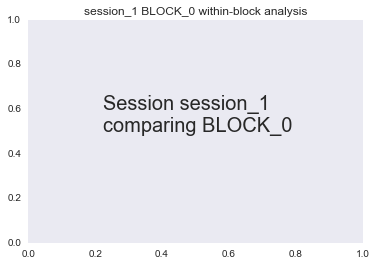

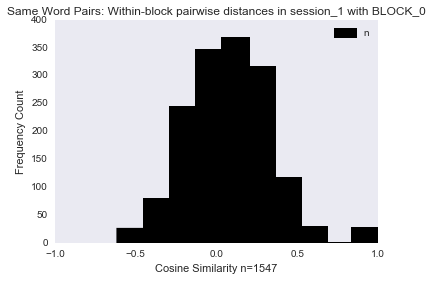

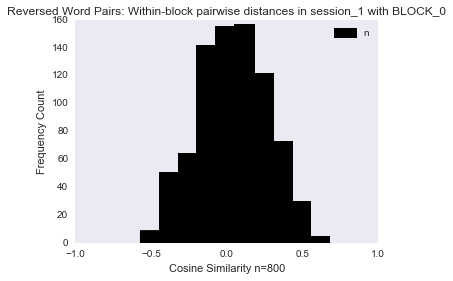

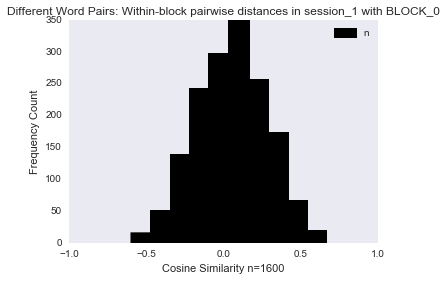

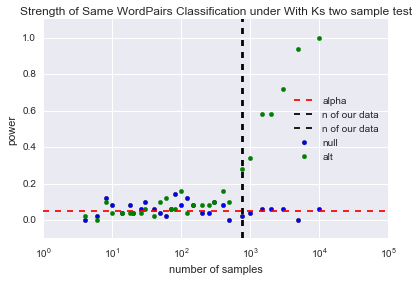

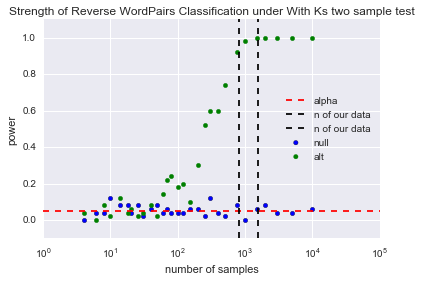

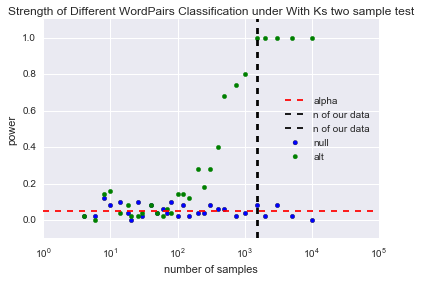

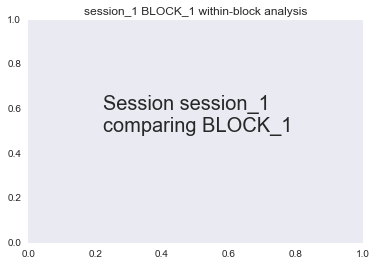

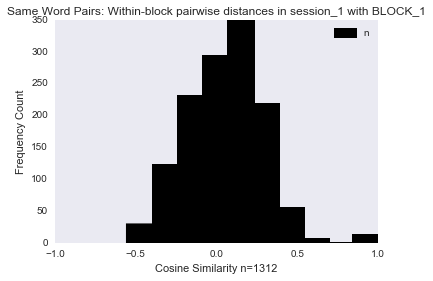

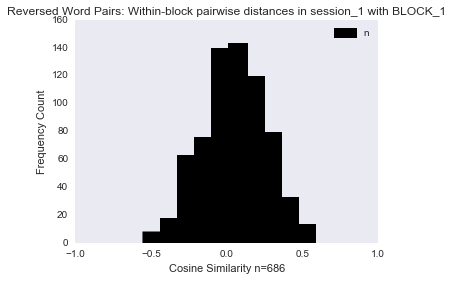

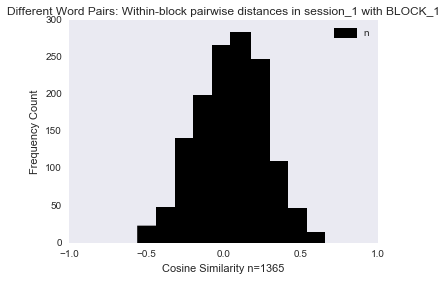

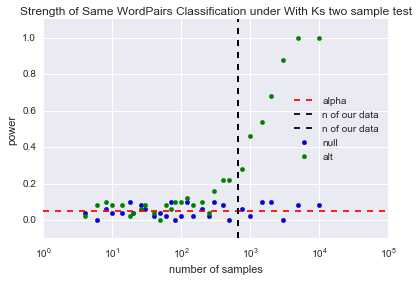

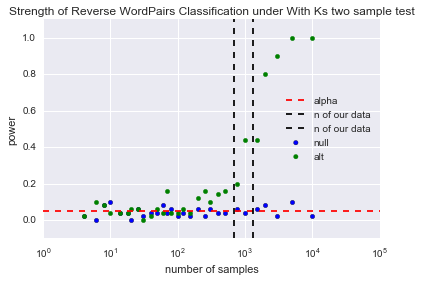

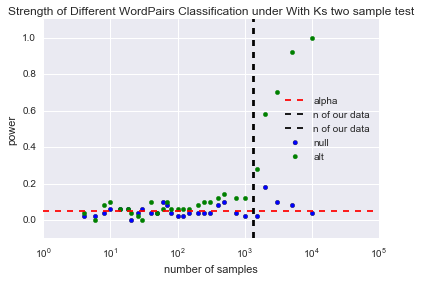

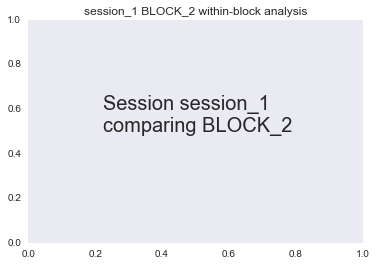

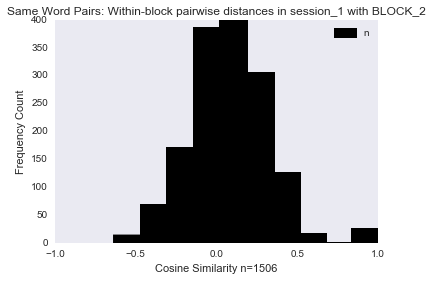

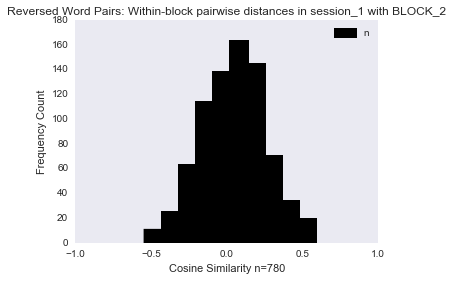

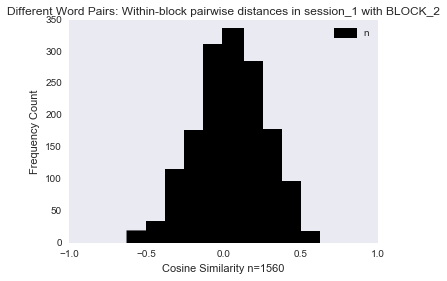

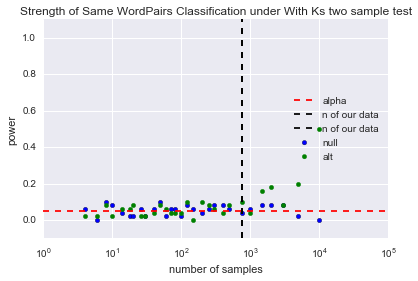

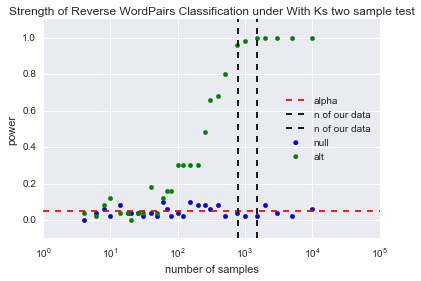

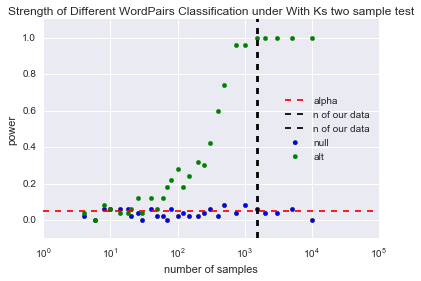

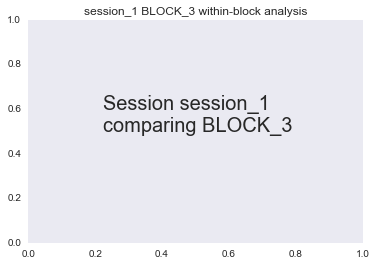

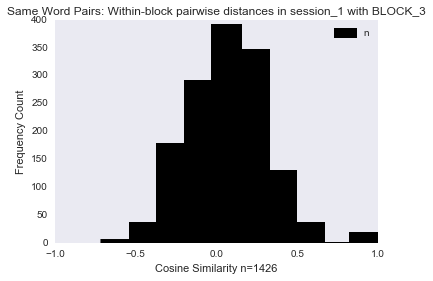

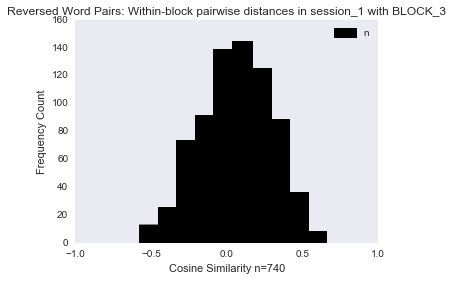

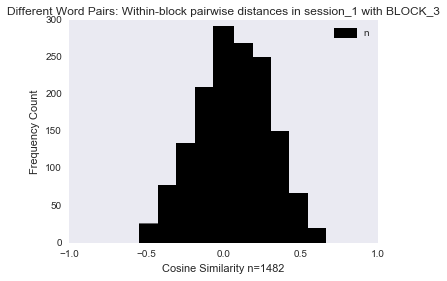

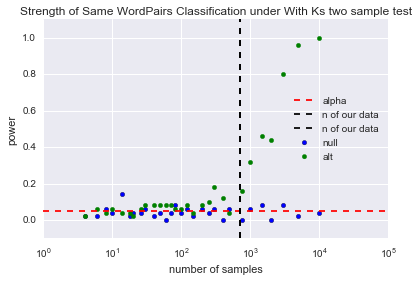

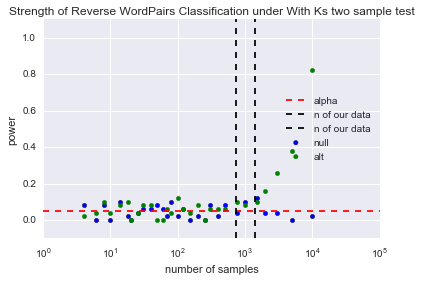

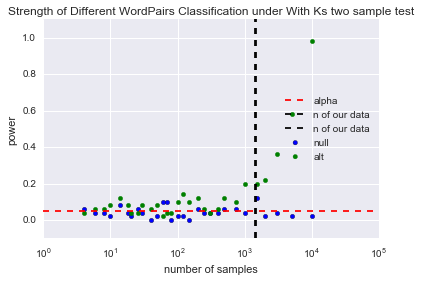

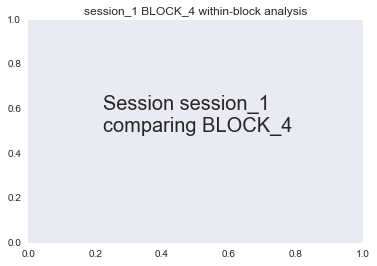

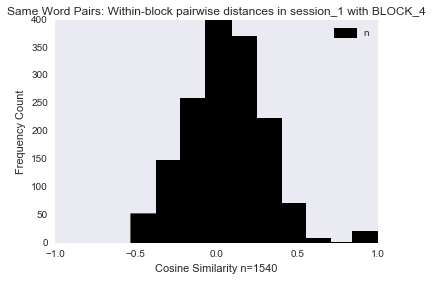

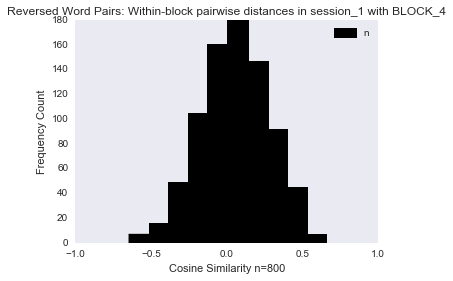

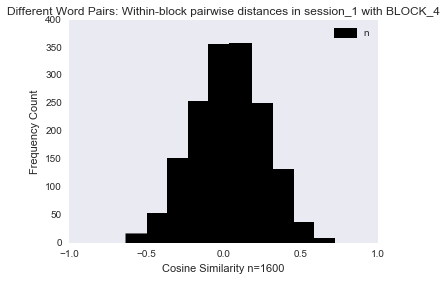

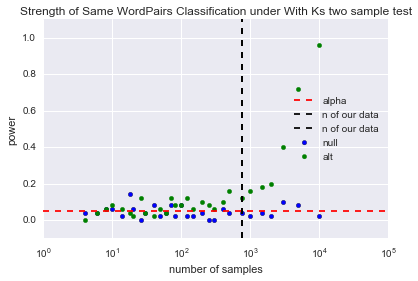

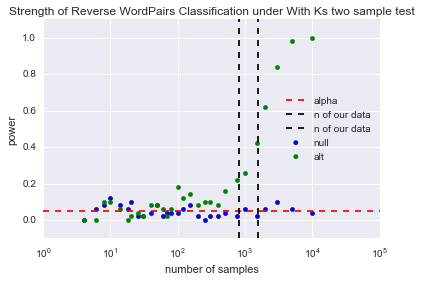

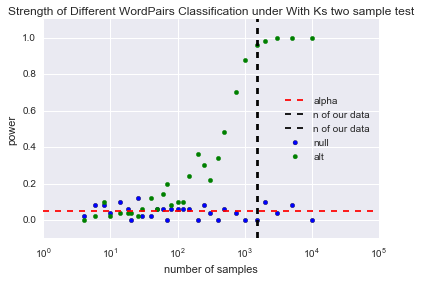

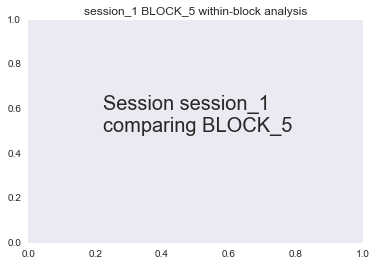

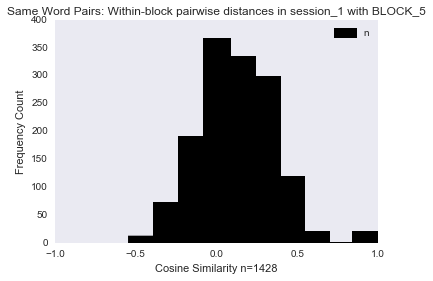

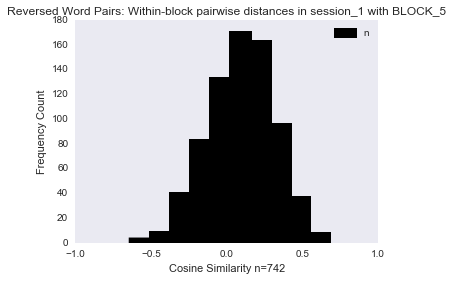

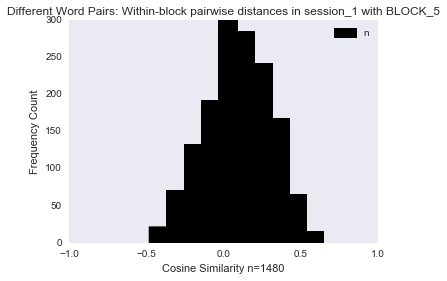

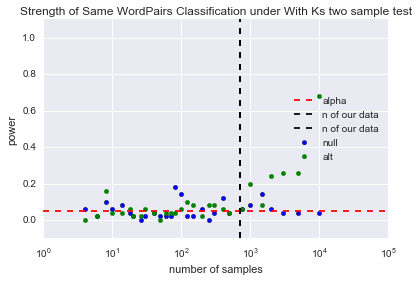

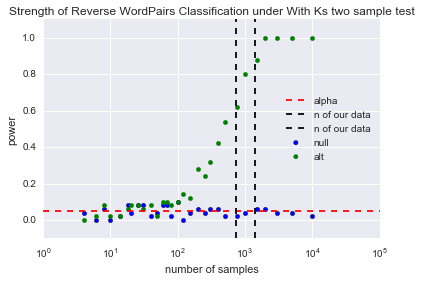

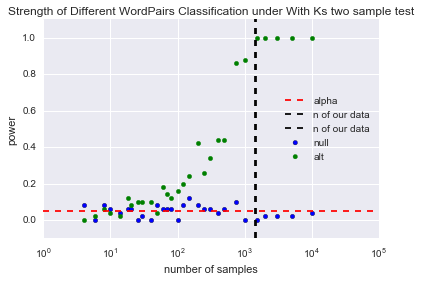

In [11]:
######## Get list of files (.mat) we want to work with ########
filedir = '../condensed_data/blocks/'
sessions = os.listdir(filedir)
sessions = sessions[2:]

# loop through each session
for session in sessions:
    print "Analyzing session ", session
    sessiondir = filedir + session
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)

    # loop through each block one at a time, analyze
    for i in range(0, 6):
        block = blocks[i]
        block_dir = sessiondir + '/' + block
        
        # in each block, get list of word pairs from first and second block
        wordpairs = os.listdir(block_dir)
       
        # within-groups analysis only has: SAME, REVERSE, DIFFERENT
        diff_word_group = []
        reverse_word_group = []
        same_word_group = []       

        #### plot meta information about which session and blocks we're analyzing
        fig=plt.figure()
        axes = plt.gca()
        ymin, ymax = axes.get_ylim()
        xmin, xmax = axes.get_xlim()
        plt.text((xmax-xmin)/4.5, (ymax-ymin)/2, r'Session %s %scomparing %s'%(session, '\n',block), fontsize=20)
        plt.title(session + ' ' + block + ' within-block analysis')
        plt.grid(False)
        
        ## 01: Create WordPair Groups
        # create same group pairs
        for idx, pair in enumerate(wordpairs):
            same_word_group.append([pair, pair])
        
        # create reverse, and different groups
        for idx, pairs in enumerate(itertools.combinations(wordpairs,2)):
            if isReverse(pairs[0], pairs[1]):
                reverse_word_group.append([pairs[0], pairs[1]])
            else:
                diff_word_group.append([pairs[0], pairs[1]])
        
        # initialize list of channels we want to look at
#         channels = os.listdir(block_dir+'/'+same_word_group[0][0]) # all channels
        channels = high_session_chans[session][0] # high frequency impact channels

        ### Go through each group and extract the feature data for each wordpair comparison
        same_feature_dict = extractFeaturesForChannel(same_word_group,session,block,block_dir, channels, low_freq_bands)
        reverse_feature_dict = extractFeaturesForChannel(reverse_word_group,session,block,block_dir, channels, low_freq_bands)
        diff_feature_dict = extractFeaturesForChannel(diff_word_group,session,block,block_dir, channels, low_freq_bands)
        
        ######################################## SAME WORD PAIRS ########################################
#         plotAllHist(same_feature_dict)
        session_same_distances = groupAllDistances(same_feature_dict)
        fig = plt.figure()
        ax = plt.gca()
        ax.grid(False)
        plt.hist(session_same_distances, color='k', lw=3)
        plt.xlabel('Cosine Similarity n='+str(len(session_same_distances)))
        plt.ylabel('Frequency Count')
        plt.title('Same Word Pairs: Within-block pairwise distances in ' + session + ' with ' + block)
        plt.xlim([-1,1])
        plt.legend(r'n= %s'%(str(len(session_same_distances))))
        plt.tight_layout()
    
        ######################################## REVERSED WORD PAIRS ########################################
#         plotAllHist(reverse_feature_dict)
        session_reverse_distances = groupAllDistances(reverse_feature_dict)
        fig = plt.figure()
        ax = plt.gca()
        ax.grid(False)
        plt.hist(session_reverse_distances, color='k', lw=3)
        plt.xlabel('Cosine Similarity n='+str(len(session_reverse_distances)))
        plt.ylabel('Frequency Count')
        plt.title('Reversed Word Pairs: Within-block pairwise distances in ' + session + ' with ' + block)
        plt.xlim([-1,1])
        plt.legend(r'n= %s'%(str(len(session_reverse_distances))))
        plt.tight_layout()
        
        ####################################### DIFFERENT WORD PAIRS ########################################        
#         plotAllHist(diff_feature_dict)
        session_diff_distances = groupAllDistances(diff_feature_dict)
        fig = plt.figure()
        ax = plt.gca()
        ax.grid(False)
        plt.hist(session_diff_distances, color='k', lw=3)
        plt.xlabel('Cosine Similarity n='+str(len(session_diff_distances)))
        plt.ylabel('Frequency Count')
        plt.title('Different Word Pairs: Within-block pairwise distances in ' + session + ' with ' + block)
        plt.xlim([-1,1])
        plt.legend(r'n= %s'%(str(len(session_diff_distances))))
        plt.tight_layout()   
        
        
        ##### RUN STATS COMPARISONS ON SAME VS. REVERSE, SAME VS. DIFF, 
        random_subset = np.random.choice(range(session_same_distances.shape[0]), size=len(session_same_distances)/2, replace=False)
        random_subset2 = list(set(np.arange(0, len(session_same_distances))) - set(random_subset))
        same_X = session_same_distances[random_subset]
        same_Y = session_same_distances[random_subset2]
        
        stat, same_p_val = stats.ks_2samp(same_X, same_Y)
        stat, reverse_p_val = stats.ks_2samp(session_same_distances, session_reverse_distances)
        stat, diff_p_val = stats.ks_2samp(session_same_distances, session_diff_distances)
           
        plotPowerSimulations(same_X, same_Y, 'Same WordPairs')
        plotPowerSimulations(session_same_distances, session_reverse_distances, 'Reverse WordPairs')
        plotPowerSimulations(session_same_distances, session_diff_distances, 'Different WordPairs')
            
        print "On block: ", block
        print "Same vs. Same comparison: %0.3f" %same_p_val
        print "Same vs. Reverse Comparison: %0.3f" %reverse_p_val
        print "Same vs. Different Comparison: %0.3f" %diff_p_val

#         break # look at 1 block
    break # look at 1 session   

In [12]:
print high_session_chans['session_1'][0]
print high_session_chans['session_2'][0]
print"%0.2f" %same_p_val

['35_TT3-global_groupSessionBlockData.mat'
 '39_OF1-global_groupSessionBlockData.mat'
 '3_G3-global_groupSessionBlockData.mat'
 '43_AST1-global_groupSessionBlockData.mat'
 '44_AST2-global_groupSessionBlockData.mat'
 '45_AST3-global_groupSessionBlockData.mat'
 '57_IO3-global_groupSessionBlockData.mat'
 '74_PP2-global_groupSessionBlockData.mat'
 '77_PP5-global_groupSessionBlockData.mat'
 '78_PP6-global_groupSessionBlockData.mat'
 '7_G7-global_groupSessionBlockData.mat']
['15_G15-global_groupSessionBlockData.mat'
 '37_TT5-global_groupSessionBlockData.mat'
 '43_AST1-global_groupSessionBlockData.mat'
 '53_PST3-global_groupSessionBlockData.mat'
 '6_G6-global_groupSessionBlockData.mat'
 '83_LP3-global_groupSessionBlockData.mat'
 '90_PPST4-global_groupSessionBlockData.mat']
0.81
